In [1]:
# define the path of the data and project
proj_path = 'D:/VScode/MRes/Clustering_under_the_ice/'
data_path = 'D:/VScode/MRes/scienceweb.whoi.edu/itp/data/'

In [6]:
#download zip data

import requests
from bs4 import BeautifulSoup
import os

'''get the filename list for files end with 'final.tar.Z' from the url'''
def get_webfile_name(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    file_name = []
    for link in soup.find_all('a'):
        if link.get('href').endswith('final.tar.Z'):
            file_name.append(link.get('href'))
    return file_name

url = 'https://scienceweb.whoi.edu/itp/data/'
file_name = get_webfile_name(url)

# file_name = [name.replace('_1', '') if '_1final.tar.Z' in name else name for name in file_name]

# check whether files on the online website exist in the data folder
def check_file(file_name):
    not_downloaded_files = []
    for i in file_name:
        file_path = os.path.join(data_path, i)
        if not os.path.exists(file_path):
            not_downloaded_files.append(i)
    return not_downloaded_files

file_name = check_file(file_name)

#download the files if the file_name list is not empty
def download_file(file_name,url):
    os.chdir(data_path)
    for i in file_name:
        file_url = url + i
        print(f' File {i} does not exist. Downloading...')
        response = requests.get(file_url)
        with open(i, 'wb') as f:
            f.write(response.content)
    os.chdir(proj_path)
    print('Download complete')

if len(file_name) > 0:
    download_file(file_name,url)
else:
    print('All .tar.Z files exist')

 File itp39_1final.tar.Z does not exist. Downloading...
Download complete


In [9]:
# readname the tar.Z files with _1 in the name
if os.path.exists(data_path+'/itp39_1final.tar.Z'):
    if os.path.exists(data_path+'/itp39final.tar.Z'):
        os.remove(data_path+'/itp39final.tar.Z')
    else:
        os.rename(data_path+'/itp39_1final.tar.Z', data_path+'/itp39final.tar.Z')
        print('rename itp39_1final.tar.Z to itp39final.tar.Z')
else:
    print('itp39_1final.tar.Z does not exist')

rename itp39_1final.tar.Z to itp39final.tar.Z


In [35]:
!pip install pyunpack

In [53]:
!pip install patool

     ---------------------------------------- 77.5/77.5 kB 4.2 MB/s eta 0:00:00


In [10]:
import os
from pyunpack import Archive
import re

# Define a set to keep track of the sensor numbers of the .dat files that have been extracted
extracted_sensors = set()

# Loop over all the .dat files in the data directory to get the list of extracted sensor numbers
for file in os.listdir(data_path):
    if file.endswith('.dat'):
        # Extract the sensor number from the file name
        sensor_num = file.split('itp')[1]
        sensor_num=re.split(r'\D+', sensor_num)[0]
        extracted_sensors.add(sensor_num)

# Extract the .tar.Z files if they are not on the extracted_sensors list
counter=0
for file in os.listdir(data_path):
    if file.endswith('.tar.Z'):
        # Extract the sensor number from the file name
        sensor_num = file.split('final')[0][3:]
        if sensor_num not in extracted_sensors:
            counter=counter+1
            try:
                # Extract the .tar.Z file
                Archive(os.path.join(data_path, file)).extractall(data_path)
                print(f'extrating {file}...')
                # Add the extracted sensor number to the extracted_sensors set
                extracted_sensors.add(sensor_num)
                
            except Exception as e:
                print(f"Error extracting {file}: {e}")
if counter==0:
    print('All files been extracted')


All files been extracted


In [2]:
# Define a function to process individual files
import pandas as pd
import xarray as xr
import numpy as np

def process_file(file,plevels):
    with open(file) as infile:
        metadata_names=infile.readline()
        metadata_vals=infile.readline().split()

    if metadata_vals[-1].isnumeric():
        if int(metadata_vals[-1])>1:
            ind=pd.read_csv(file,sep='\s+',header=2,engine='python',skipfooter=1,index_col=0)
            try:
                ds=ind.to_xarray().rename({'%pressure(dbar)':'pressure','temperature(C)':'temperature'})
                ds = xr.Dataset({'pressure': ds['pressure'],'temperature': ds['temperature'],'salinity':ds['salinity']})
            except ValueError:
                return None

            ds=ds.assign_coords({'profiler':int(metadata_names.split(':')[0].split(',')[0].split(' ')[1]),
                                 'date':np.datetime64(pd.Timestamp(metadata_vals[0])+pd.Timedelta(float(metadata_vals[1]),'D')),
                                  'lon':float(metadata_vals[2]),
                                  'lat':float(metadata_vals[3])}
                                 )
            ds=ds.drop_duplicates('pressure',keep='last')
            if 'dissolved_oxygen' in ds:
                ds=ds.drop('dissolved_oxygen')
            if ds.pressure.size>1:    #ds['pressure'][-1].values>pend:
                return ds.interp({'pressure':plevels},assume_sorted=True) # interpolate the pressure levels
            else:
                return None
        else:
            return None
    else:
        return None

In [10]:
import glob
import numpy as np
import pandas as pd
import xarray as xr

files = glob.glob(f'{data_path}/*.dat')
print(f'Total {len(files)} files found.')

pstart=10
pend=750.
plevels=np.arange(pstart,pend,5.)

# define a list to hold the individual xarray datasets
datasets = []

counter=0
# loop through files and process each one
for file in files:
    ds = process_file(file, plevels)
    if ds is not None:
        datasets.append(ds)
        # counter=counter+1
        # if counter==100:
        #     break

# concatenate the individual xarray datasets into a single xarray dataset
ds_all = xr.concat(datasets, dim='nprof')

Total 106013 files found.


In [11]:
ds_all

<xarray.Dataset>
Dimensions:      (nprof: 88774, pressure: 148)
Coordinates:
    profiler     (nprof) int32 100 100 100 100 100 100 100 100 ... 9 9 9 9 9 9 9
    date         (nprof) datetime64[ns] 2017-09-20T00:02:04.416000 ... 2009-0...
    lon          (nprof) float64 -149.2 -149.1 -148.8 ... -95.51 -95.29 -95.09
    lat          (nprof) float64 80.04 80.07 80.1 80.12 ... 82.75 82.76 82.76
  * pressure     (pressure) float64 10.0 15.0 20.0 25.0 ... 735.0 740.0 745.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 -1.495 -1.495 -1.342 ... 0.231 0.2258
    salinity     (nprof, pressure) float64 27.8 27.81 28.08 ... 34.88 34.88

In [1]:
# save the xarry to local file
ds_all.to_netcdf(f"{data_path}/ds_all.nc")

NameError: name 'ds_all' is not defined

In [4]:
# read the xarray from local file
import xarray as xr
ds_all=xr.open_dataset(f"{data_path}/ds_all.nc")
ds_all['pressure']=-ds_all['pressure']
ds_all

<xarray.Dataset>
Dimensions:      (nprof: 88774, pressure: 148)
Coordinates:
    profiler     (nprof) int32 ...
    date         (nprof) datetime64[ns] ...
    lon          (nprof) float64 ...
    lat          (nprof) float64 ...
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -735.0 -740.0 -745.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 ...
    salinity     (nprof, pressure) float64 ...

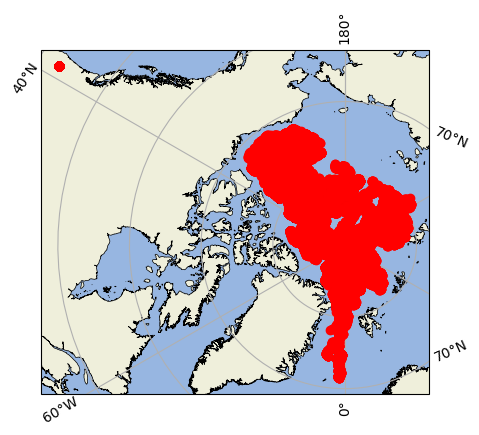

In [33]:
# plot the locations of all data
import plot_toolbox as ptb
ptb.plot_data_location(ds_all,dpi=100)

In [5]:
# remove nan values
pstart=-10.
pend=-500.
ds_cleaned=ds_all.sel(pressure=slice(pstart,pend)).dropna('nprof')
ds_cleaned


<xarray.Dataset>
Dimensions:      (nprof: 48074, pressure: 99)
Coordinates:
    profiler     (nprof) int32 ...
    date         (nprof) datetime64[ns] ...
    lon          (nprof) float64 ...
    lat          (nprof) float64 ...
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 -1.495 -1.495 -1.342 ... 0.422 0.4203
    salinity     (nprof, pressure) float64 27.8 27.81 28.08 ... 34.84 34.84

In [26]:
# remove the data with lat<60
ds_cleaned=ds_cleaned.where(ds_cleaned.lat>60,drop=True)
ds_cleaned

<xarray.Dataset>
Dimensions:      (nprof: 47890, pressure: 99)
Coordinates:
    profiler     (nprof) int32 100 100 100 100 100 100 100 100 ... 9 9 9 9 9 9 9
    date         (nprof) datetime64[ns] 2017-09-20T00:02:04.416000 ... 2009-0...
    lon          (nprof) float64 -149.2 -148.8 -148.0 ... -97.41 -95.51 -95.29
    lat          (nprof) float64 80.04 80.1 80.18 80.28 ... 82.65 82.75 82.76
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 -1.495 -1.495 -1.342 ... 0.422 0.4203
    salinity     (nprof, pressure) float64 27.8 27.81 28.08 ... 34.84 34.84

In [28]:
# save the cleaned xarry to local file
ds_cleaned.to_netcdf(f"{data_path}/ds_cleaned.nc")

In [2]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned=xr.open_dataset(f"{data_path}/ds_cleaned.nc")

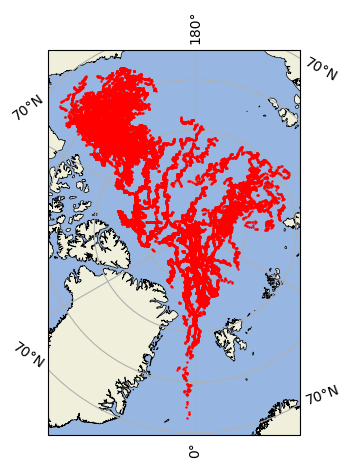

In [3]:
# plot the locations of cleaned data
import plot_toolbox as ptb
ptb.plot_data_location(ds_cleaned,dpi=100)